# Stanford CS25: Self-Attention and Non-Parametric Transformers (NPTs)

Welcome! This notebook is your guide to understanding Non-Parametric Transformers (NPTs), a fascinating type of deep learning model. We'll explore concepts from the research paper "Self-Attention Between Datapoints: Going Beyond Individual Input-Output Pairs in Deep Learning" (arXiv:2106.02584v2) and connect them to ideas from the Stanford CS25 lecture series.

**Goal:** To provide beginners with clear, in-depth explanations, visualizations, interactive examples, and code to build a strong intuition for NPTs and how they leverage self-attention in a novel way.

**Why NPTs?** Traditional deep learning models learn a fixed set of parameters from training data and then use these parameters to make predictions on new, individual inputs. NPTs challenge this by considering the *entire dataset* (or a large chunk of it) when making a prediction for a new input. This allows them to explicitly model relationships *between* datapoints, going beyond the standard paradigm.

## Prerequisites
A basic understanding of Python and some familiarity with machine learning concepts will be helpful. We'll be using the following libraries:
- `numpy` for numerical operations.
- `matplotlib` and `seaborn` for plotting.
- `torch` (PyTorch) for building and understanding neural network components.
- `ipywidgets` for interactive elements.

Let's install them if you haven't already:

In [1]:
!pip install numpy matplotlib seaborn torch ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

And if you're in a Jupyter environment, enable ipywidgets:

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## Table of Contents
1.  [Introduction: Beyond Individual Inputs](#intro)
2.  [Background: Self-Attention Mechanisms](#self-attention)
3.  [Non-Parametric Transformers (NPTs): The Core Idea](#npt-core)
    *   [Datasets as Inputs](#datasets-as-inputs)
    *   [NPT Architecture Overview](#npt-architecture)
    *   [Attention Between Datapoints (ABD)](#abd)
    *   [Attention Between Attributes (ABA)](#aba)
    *   [Permutation Equivariance](#equivariance)
    *   [Masking and Optimization](#masking-optimization)
4.  [How NPTs Learn: Key Experiments](#experiments)
    *   [Performance on Tabular and Image Data](#benchmarks)
    *   [Learning to Lookup: Semi-Synthetic Tasks](#semi-synthetic)
    *   [Real-World Data: Using Inter-Datapoint Attention](#real-data-attention)
5.  [Ablation Studies: What Makes NPTs Tick?](#ablation)
6.  [Computational Considerations and Societal Impacts](#computational-societal)
7.  [Interactive Playground](#interactive)
8.  [Conclusion](#conclusion)

<a id='intro'></a>
## 1. Introduction: Beyond Individual Inputs

Most supervised deep learning models operate on a common assumption: a prediction for a given input depends *only* on the model's learned parameters and the features of that *single input*. For example, to classify an image of a cat, the model uses its learned weights and the pixels of that specific cat image.

The NPT paper [1, Abstract] challenges this. It introduces a general-purpose deep learning architecture that takes the **entire dataset** as input, not just one datapoint at a time. This allows the model to explicitly reason about relationships *between* datapoints.

**Parametric vs. Non-Parametric (in this context):**
- **Parametric Models:** Learn a fixed set of parameters `θ` from training data `D_train`. At test time, predictions for `x*` are `p(y* | x*; θ)`. They don't directly use `D_train` during prediction (except for its influence on `θ`).
- **Non-Parametric Models (Traditional Statistics):** Predictions explicitly depend on the training data `p(y* | x*, D_train)`. Think of k-Nearest Neighbors (k-NN), where predictions for `x*` depend on its neighbors in `D_train`.
- **Non-Parametric Transformers (NPTs):** NPTs aim to bridge this. They use parametric attention mechanisms (learnable weights) to realize non-parametric modeling. They learn *how* to use other datapoints from `D_train` for prediction, described as `p(y* | x*, D_train; θ)`. [1, Introduction]

This approach allows NPTs to perform tasks that are difficult for traditional deep learning models, such as cross-datapoint lookup and complex reasoning that involves comparing multiple data instances.

<a id='self-attention'></a>
## 2. Background: Self-Attention Mechanisms

Before diving into NPTs, let's briefly revisit self-attention, a core component of Transformers and NPTs.

Self-attention allows a model to weigh the importance of different parts of an input sequence when processing any part of that sequence. For a sequence of input embeddings (e.g., word embeddings in a sentence, or feature embeddings of a datapoint), self-attention computes a new representation for each element by attending to all elements in the sequence.

**Key Components: Queries, Keys, Values**
For each input element, we create three vectors:
- **Query (Q):** Represents the current element's 'question' – what information is it looking for?
- **Key (K):** Represents other elements' 'label' or 'identifier' – what kind of information do they offer?
- **Value (V):** Represents the actual content or information of other elements.

**The Process:**
1.  **Score:** For a given Query, compute its similarity with all Keys. A common way is the dot product: `score = Q · K^T`.
2.  **Scale:** Scale the scores by the square root of the dimension of the key vectors (`sqrt(d_k)`) to stabilize gradients.
3.  **Weights (Softmax):** Apply a softmax function to the scaled scores to get attention weights. These weights sum to 1 and indicate how much attention each Query should pay to each Key-Value pair.
4.  **Output:** Compute a weighted sum of the Values based on these attention weights.

**Formula:**
$$ 	ext{Attention}(Q, K, V) = 	ext{softmax}\left(
rac{QK^T}{\sqrt{d_k}}
ight)V $$

**Multi-Head Self-Attention (MHSA):** [1, Section 2.3]
Instead of performing a single attention function, MHSA runs multiple self-attention operations (called 'heads') in parallel. Each head learns different types of relationships because they use different, learned linear projections for Q, K, and V. The outputs of these heads are then concatenated and linearly projected to produce the final output.

Analogy: Imagine trying to understand a complex scene. Different attention heads are like focusing on different aspects simultaneously – one head might focus on colors, another on shapes, and another on the spatial arrangement of objects. Combining these gives a richer understanding.

Input shape: torch.Size([1, 5, 8])
Attention Output shape: torch.Size([1, 5, 8])
Attention Weights shape: torch.Size([1, 5, 5])


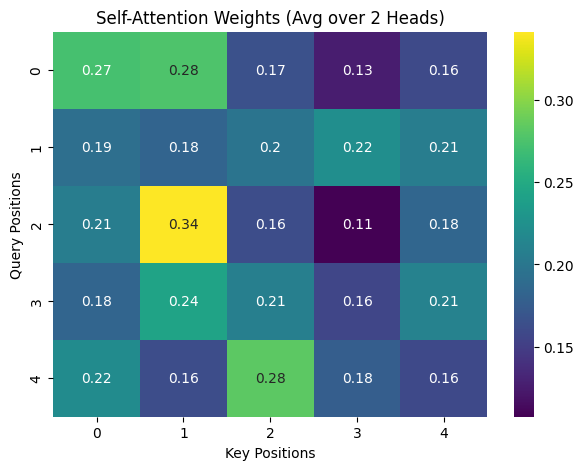

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example: MHSA for a small sequence
seq_len = 5  # Number of items in the sequence (e.g., 5 words)
embed_dim = 8 # Embedding dimension for each item
num_heads = 2  # Number of attention heads

# Create some dummy input data (batch_size=1, seq_len, embed_dim)
dummy_input = torch.randn(1, seq_len, embed_dim)

# PyTorch's MultiheadAttention layer
# Note: PyTorch's MHA expects input as (seq_len, batch_size, embed_dim) if batch_first=False (default)
# or (batch_size, seq_len, embed_dim) if batch_first=True.
# Here, we'll permute our dummy_input for the default batch_first=False.
mha_layer = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

# Get the attention output and weights
# Q, K, V are all the same for self-attention
attn_output, attn_weights = mha_layer(dummy_input, dummy_input, dummy_input)

print("Input shape:", dummy_input.shape)
print("Attention Output shape:", attn_output.shape) # (batch_size, seq_len, embed_dim)
print("Attention Weights shape:", attn_weights.shape) # (batch_size, seq_len, seq_len) - avg over heads by default in output

# Visualize attention weights for the first (and only) batch item
plt.figure(figsize=(7, 5))
sns.heatmap(attn_weights[0].detach().numpy(), annot=True, cmap='viridis')
plt.title(f'Self-Attention Weights (Avg over {num_heads} Heads)')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()

In the heatmap above, each cell (i, j) shows how much attention item `i` (Query) pays to item `j` (Key). Darker colors mean higher attention. NPTs will use this fundamental mechanism in two distinct ways: between datapoints and between attributes within a datapoint.

<a id='npt-core'></a>
## 3. Non-Parametric Transformers (NPTs): The Core Idea

NPTs introduce a novel way to think about how deep learning models process information, moving beyond individual input-output pairs to consider the entire dataset.

<a id='datasets-as-inputs'></a>
### 3.1. Datasets as Inputs [1, Section 2.1]

The most fundamental shift NPTs propose is treating the **entire dataset `X` as a single input** to the model. This dataset `X` is typically a matrix of shape `n x d`, where `n` is the number of datapoints and `d` is the number of attributes (features + target(s)).

- **Rows `X_i`**: Represent individual datapoints (e.g., a specific patient's record, a particular house's features).
- **Columns `X_:,j`**: Represent attributes (e.g., age, blood pressure, house size, price).

This is a departure from standard supervised learning where the input `x` is a single row (or a minibatch of rows, processed independently in terms of their inter-relationships).

**Masking for Prediction:**
Similar to masked language modeling (like in BERT), NPTs use a binary mask matrix `M` of the same shape `n x d`.
- `M_ij = 1` means the value `X_ij` is masked (unknown) and the model needs to predict it.
- `M_ij = 0` means `X_ij` is observed.

The task is to predict the masked values `X^M` given the observed values `X^O`, i.e., `p(X^M | X^O)`. For standard regression/classification, the mask `M` would have 1s only in the target column for the entries we want to predict (e.g., test set targets).

<a id='npt-architecture'></a>
### 3.2. NPT Architecture Overview [1, Section 2.2, Fig 2]

The NPT architecture is designed to process this entire dataset matrix. Here's a high-level overview (refer to Fig. 2 in the paper):

1.  **Input:** The dataset `X` (n x d) and mask `M` (n x d).
2.  **Embedding (Fig 2b):**
    *   Each of the `n` datapoints (rows) is independently embedded. Categorical features are typically one-hot encoded, continuous features standardized.
    *   These, along with mask information and potentially positional/type embeddings for attributes, are linearly projected into an `e`-dimensional space.
    *   This results in an initial representation `H^(0)` of shape `n x d x e`.
3.  **Alternating Attention Layers (Fig 2c, 2d):**
    *   The core of NPT consists of a stack of layers. Each layer typically involves two types of multi-head self-attention applied alternatingly:
        *   **Attention Between Datapoints (ABD):** Operates across the `n` datapoints for each attribute representation.
        *   **Attention Between Attributes (ABA):** Operates across the `d` attributes for each datapoint independently.
4.  **Output Projection:** After several such alternating layers, a final linear projection maps the processed representations back to the original data space to predict the masked values `X_hat`.

Let's visualize the data flow:

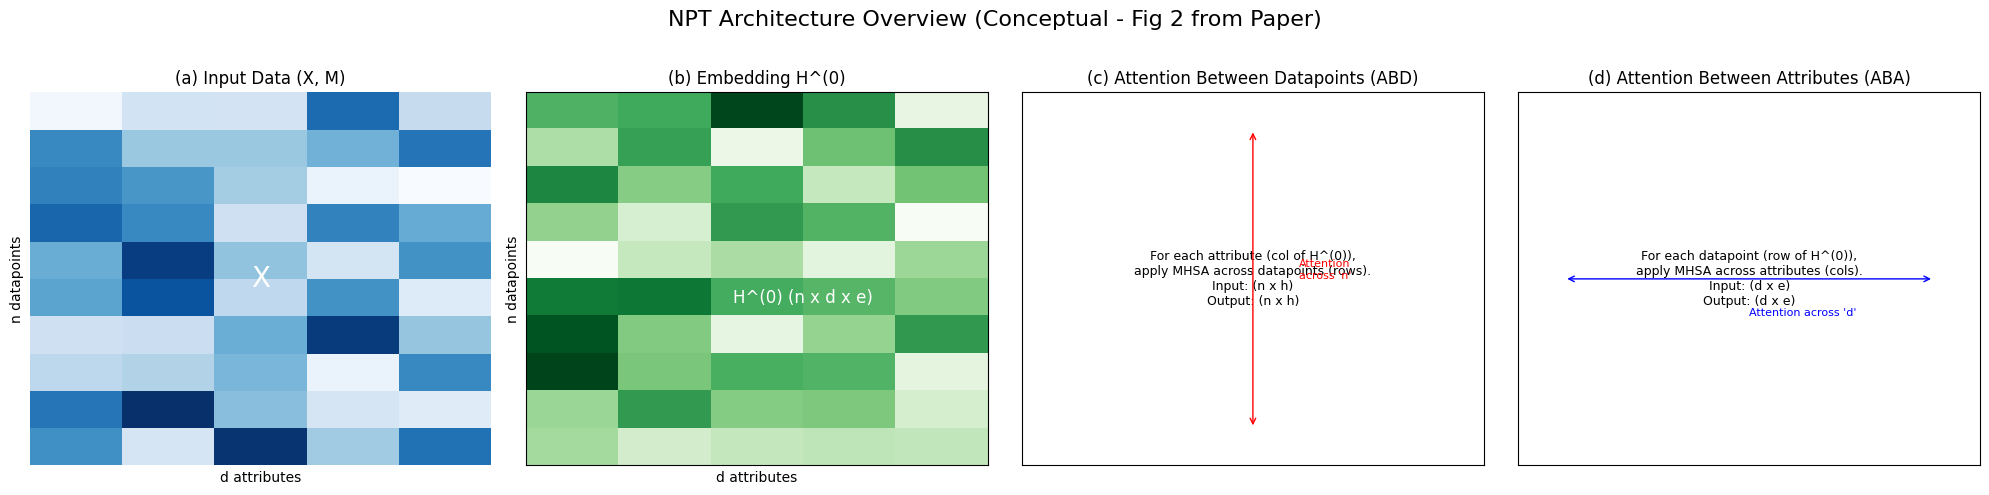

In [4]:
def plot_npt_overview():
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    plt.suptitle("NPT Architecture Overview (Conceptual - Fig 2 from Paper)", fontsize=16)

    # (a) Input Data
    axs[0].set_title("(a) Input Data (X, M)")
    data_matrix = np.random.rand(10, 5) # n=10, d=5
    mask_matrix = np.random.randint(0, 2, (10,5))
    sns.heatmap(data_matrix, ax=axs[0], cbar=False, annot=False, cmap="Blues_r", yticklabels=False, xticklabels=False)
    axs[0].set_xlabel("d attributes")
    axs[0].set_ylabel("n datapoints")
    axs[0].text(2.5, 5, "X", ha='center', va='center', fontsize=20, color='white')

    # (b) Embedding
    axs[1].set_title("(b) Embedding H^(0)")
    # Conceptually, each (datapoint, attribute) pair gets an embedding vector 'e'
    # We simplify visualization to show an expanded representation
    embedded_data = np.random.rand(10, 5, 3) # n, d, e (e=3 for viz)
    axs[1].imshow(np.mean(embedded_data, axis=2), cmap="Greens_r", aspect='auto') # Show mean over 'e'
    axs[1].set_xlabel("d attributes")
    axs[1].set_ylabel("n datapoints")
    axs[1].text(2.5, 5, "H^(0) (n x d x e)", ha='center', va='center', fontsize=12, color='white')
    axs[1].set_yticks([])
    axs[1].set_xticks([])

    # (c) Datapoint Attention (ABD)
    axs[2].set_title("(c) Attention Between Datapoints (ABD)")
    # Input H^(l) (n x d x e) is flattened to (n x h) where h = d*e
    # MHSA applied across 'n' dimension
    axs[2].text(0.5, 0.5, "For each attribute (col of H^(0)),\napply MHSA across datapoints (rows).\nInput: (n x h)\nOutput: (n x h)",
                ha='center', va='center', fontsize=9, wrap=True)
    axs[2].set_xlim(0,1)
    axs[2].set_ylim(0,1)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].annotate("", xy=(0.5, 0.1), xytext=(0.5, 0.9), arrowprops=dict(arrowstyle="<->", color='red'))
    axs[2].text(0.6, 0.5, "Attention\nacross 'n'", color='red', fontsize=8)

    # (d) Attribute Attention (ABA)
    axs[3].set_title("(d) Attention Between Attributes (ABA)")
    # Input H^(l) (n x d x e)
    # MHSA applied across 'd' dimension independently for each 'n'
    axs[3].text(0.5, 0.5, "For each datapoint (row of H^(0)),\napply MHSA across attributes (cols).\nInput: (d x e)\nOutput: (d x e)",
                ha='center', va='center', fontsize=9, wrap=True)
    axs[3].set_xlim(0,1)
    axs[3].set_ylim(0,1)
    axs[3].set_xticks([])
    axs[3].set_yticks([])
    axs[3].annotate("", xy=(0.1, 0.5), xytext=(0.9, 0.5), arrowprops=dict(arrowstyle="<->", color='blue'))
    axs[3].text(0.5, 0.4, "Attention across 'd'", color='blue', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('npt_overview.png')
    plt.show()

plot_npt_overview()

<a id='abd'></a>
### 3.3. Attention Between Datapoints (ABD) [1, Section 2.4]

ABD is a key operation that allows NPTs to explicitly model relationships between *different datapoints*.

**Process:**
1.  The input to an ABD layer is typically a representation `H^(l)` of shape `n x d x e` (output from the previous layer or initial embedding).
2.  This tensor is flattened or reshaped. The paper states it's flattened from `n x d x e` to `n x h` where `h = d * e`. (Fig 2c suggests attention is applied across `n` samples of hidden dimension `h=d*e`. This means for each of the `n` datapoints, we have one large vector of size `d*e` representing it.)
3.  Multi-Head Self-Attention (MHSA) is then applied to these `n` representations (each of dimension `h`).
    *   Each datapoint's representation `H^(l)_i` (now a vector of size `h`) generates a Query, Key, and Value.
    *   Attention scores are computed between all pairs of datapoints.
    *   This allows each datapoint to update its representation by aggregating information from all other datapoints in the current batch/dataset.
4.  The output `H^(l+1)` is of shape `n x h`, which is then reshaped back to `n x d x e` for the subsequent ABA layer (or if it's the final ABD in a block before an rFF, the rFF is applied independently to each of the `n` datapoints).

**Intuition:** ABD allows the model to learn, for example, that to predict the price of *house A*, it might be useful to look at the features of *house B* and *house C* if they are similar or relevant in some learned way.

**Example Simulation:** Let's simulate ABD for a few datapoints. We'll assume `h` is the effective embedding dimension per datapoint after flattening `d x e`.

ABD Input shape (H_for_abd): torch.Size([1, 6, 16])
ABD Output shape: torch.Size([1, 6, 16])
ABD Attention Weights shape: torch.Size([1, 6, 6])


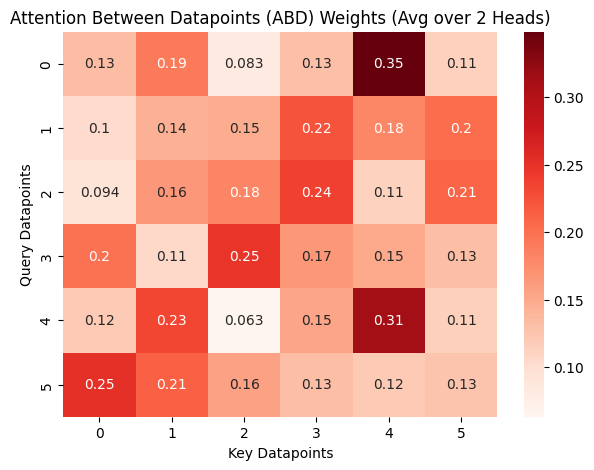

In [5]:
# Simulate ABD
n_datapoints = 6
h_dim = 16 # d*e, effective dimension per datapoint for ABD
num_abd_heads = 2

# Dummy representation for n_datapoints, each of h_dim
# This would be H^(l) after reshaping/flattening
H_for_abd = torch.randn(1, n_datapoints, h_dim) # (batch_size=1, num_datapoints, h_dim)

abd_mha_layer = nn.MultiheadAttention(embed_dim=h_dim, num_heads=num_abd_heads, batch_first=True)
abd_output, abd_attn_weights = abd_mha_layer(H_for_abd, H_for_abd, H_for_abd)

print("ABD Input shape (H_for_abd):", H_for_abd.shape)
print("ABD Output shape:", abd_output.shape)
print("ABD Attention Weights shape:", abd_attn_weights.shape)

plt.figure(figsize=(7, 5))
sns.heatmap(abd_attn_weights[0].detach().numpy(), annot=True, cmap='Reds')
plt.title(f'Attention Between Datapoints (ABD) Weights (Avg over {num_abd_heads} Heads)')
plt.xlabel('Key Datapoints')
plt.ylabel('Query Datapoints')
plt.savefig('abd_attention_weights.png')
plt.show()

The heatmap for ABD shows how much each datapoint (Query) attends to other datapoints (Keys) when updating its representation. A dark cell at `(i, j)` means datapoint `i` heavily considers datapoint `j`.

<a id='aba'></a>
### 3.4. Attention Between Attributes (ABA) [1, Section 2.5]

ABA allows the model to learn relationships and transformations *within each datapoint* independently, across its attributes.

**Process:**
1.  The input to an ABA layer is `H^(l)` of shape `n x d x e`.
2.  For ABA, MHSA is applied independently to each of the `n` datapoints.
3.  For a single datapoint `i`, its representation is `H^(l)_i` of shape `d x e`. This is treated as a sequence of `d` items (attributes), each with embedding dimension `e`.
4.  MHSA is applied to this sequence of `d` attribute embeddings.
    *   Each attribute's embedding `H^(l)_i,j` (for datapoint `i`, attribute `j`) generates a Query, Key, and Value.
    *   Attention scores are computed between all pairs of attributes *within that specific datapoint*.
    *   This allows each attribute to update its representation by aggregating information from other attributes of the *same datapoint*.
5.  This is done for all `n` datapoints (often batched over `n` for efficiency). The output `H^(l+1)` is of the same shape `n x d x e`.

**Intuition:** ABA allows the model to learn, for example, that if a house has many bedrooms (attribute 1), its size (attribute 2) is likely to be large, and this relationship can inform the representation of both attributes for that house.

**Example Simulation:** Let's simulate ABA for a single datapoint with several attributes.

ABA Input shape (H_datapoint_for_aba): torch.Size([1, 5, 8])
ABA Output shape: torch.Size([1, 5, 8])
ABA Attention Weights shape: torch.Size([1, 5, 5])


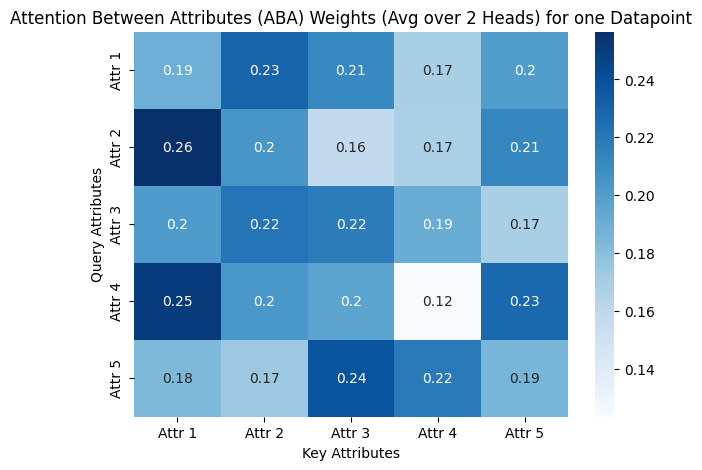

In [6]:
# Simulate ABA for one datapoint
d_attributes = 5
e_dim = 8 # embedding dim per attribute
num_aba_heads = 2

# Dummy representation for 1 datapoint with d_attributes, each of e_dim
# This would be H^(l)_i from H^(l) of shape (n x d x e)
H_datapoint_for_aba = torch.randn(1, d_attributes, e_dim) # (batch_size=1, num_attributes, e_dim)

aba_mha_layer = nn.MultiheadAttention(embed_dim=e_dim, num_heads=num_aba_heads, batch_first=True)
aba_output, aba_attn_weights = aba_mha_layer(H_datapoint_for_aba, H_datapoint_for_aba, H_datapoint_for_aba)

print("ABA Input shape (H_datapoint_for_aba):", H_datapoint_for_aba.shape)
print("ABA Output shape:", aba_output.shape)
print("ABA Attention Weights shape:", aba_attn_weights.shape)

plt.figure(figsize=(7, 5))
sns.heatmap(aba_attn_weights[0].detach().numpy(), annot=True, cmap='Blues')
custom_labels = [f'Attr {i+1}' for i in range(d_attributes)]
plt.xticks(ticks=np.arange(d_attributes) + 0.5, labels=custom_labels)
plt.yticks(ticks=np.arange(d_attributes) + 0.5, labels=custom_labels)
plt.title(f'Attention Between Attributes (ABA) Weights (Avg over {num_aba_heads} Heads) for one Datapoint')
plt.xlabel('Key Attributes')
plt.ylabel('Query Attributes')
plt.savefig('aba_attention_weights.png')
plt.show()

The heatmap for ABA shows how much each attribute (Query) attends to other attributes (Keys) *within the same datapoint*. A dark cell at `(i, j)` means attribute `i` heavily considers attribute `j` when updating its own representation for that specific datapoint.

By alternating ABD and ABA layers, NPTs can model complex dependencies both between datapoints and within individual datapoints.

<a id='equivariance'></a>
### 3.5. Permutation Equivariance [1, Property 1, Appendix A]

A crucial property of NPTs is their **equivariance to permutations of datapoints**. This means if you shuffle the rows (datapoints) of the input dataset `X`, the NPT will produce the same predictions, just shuffled in the same way.

**Why is this important?**
In many datasets, the order of datapoints doesn't inherently carry meaning. For instance, a dataset of patient records could be sorted by age, ID, or randomly; the underlying relationships the model should learn are independent of this ordering. Permutation equivariance bakes this assumption directly into the model architecture.

**How is it achieved?**
This property holds because all components of NPTs that operate on the datapoint dimension (`n`) are themselves permutation equivariant.
- **Self-Attention (used in ABD):** Multi-head self-attention is permutation equivariant. If you shuffle the input sequence, the output sequence is simply the shuffled version of the original output. (The proof details are in Appendix A of the paper, showing that row-wise operations and the self-attention mechanism preserve this property under permutation of rows).
- **Row-wise operations:** Operations like the initial embedding (applied independently to each row) or the row-wise feed-forward networks (rFF) in MHSA layers are inherently equivariant to row permutations.
- **ABA:** ABA applies attention independently to each datapoint (row). Shuffling the datapoints just shuffles which independent computation is done where, so the set of outputs is the same, just permuted.

Since NPTs are a composition of permutation-equivariant functions, the entire NPT architecture is permutation equivariant with respect to its datapoints.

**Analogy:** Imagine a voting system where each voter casts their vote independently. The final tally (e.g., sum of votes for each candidate) doesn't change if you change the order in which voters cast their votes. Similarly, ABD processes all datapoints, and the overall learned relationships are robust to the initial ordering of these datapoints.

<a id='masking-optimization'></a>
### 3.6. Masking and Optimization [1, Section 2.6]

NPTs are trained to predict masked entries in the input dataset. This involves clever masking strategies and a specific objective function.

**Masking Strategies:**
The model needs to predict `p(X^M | X^O)`, where `X^M` are masked values and `X^O` are observed values. The paper details two types of stochastic masking applied during training:

1.  **Stochastic Feature Masking:**
    *   Input features `X_ij` (where `j != d`, assuming `d` is the target column) are randomly masked with a probability `p_feature` (e.g., 0.15).
    *   This encourages the model to learn a robust representation of the entire dataset, as it needs to predict features from other features and datapoints.
    *   It acts as a form of self-supervision and regularization.

2.  **Stochastic Target Masking:**
    *   Target values `X_i,d` in the training set are also stochastically masked with probability `p_target`.
    *   **Crucially, this means that many training targets are *unmasked* (visible) to the model during a training step.**
    *   This allows NPTs to learn to predict masked targets of some training datapoints by *looking up or reasoning about the targets of other (unmasked) training datapoints*. This is a key mechanism for NPTs to learn inter-datapoint relationships for the primary prediction task.
    *   Care is taken to never reveal test set targets.

**NPT Objective (Loss Function):**
During training, the objective is a combination of a loss on predicting training targets and an auxiliary loss on predicting masked-out features:
$$ L_{NPT} = (1 - \lambda) L_{Targets} + \lambda L_{Features} $$
Where:
- `L_Targets`: Negative log-likelihood loss for the masked training targets.
- `L_Features`: Auxiliary loss for the masked-out input features.
- `\lambda`: A hyperparameter that balances the two losses. The paper mentions annealing `\lambda` (e.g., from 1 to 0) over the course of training, initially focusing on feature reconstruction and gradually shifting to target prediction. [1, Appendix C.1.1, C.5]

At test time, only `L_Targets` is computed on the test set targets (which are always masked from the model's input).

**Handling Large Datasets (Minibatching):** [1, Section 2.6]
Self-attention has a quadratic complexity `O(n^2)` with respect to the number of datapoints `n`. For large datasets, processing the entire dataset at once is infeasible.
NPTs address this using **minibatching**:
- The data is processed in random subsets (minibatches).
- At test time, minibatches are constructed such that **both training and test data are present in the same batch**. This is vital for NPTs to attend to training datapoints when making predictions for test datapoints.

**Further Masking Details (from Appendix C.4):**
- **Handling Missing Values:** NPTs can naturally handle missing values by simply treating them as masked entries (`M_ij = 1`) from the start. No explicit imputation pre-processing is needed. The model learns to predict/impute them based on other data.
- **Versatile ML Settings:** The masking mechanism allows NPTs to tackle various tasks:
    *   **Multi-Target Prediction:** Mask multiple target columns.
    *   **Self-Supervision:** Mask input features and learn to reconstruct them.
    *   **Semi-Supervision:** Include unlabeled data by masking their target columns entirely, allowing the model to leverage their features via ABD.
    *   **Imputation:** The core task of predicting any masked entry.

<a id='experiments'></a>
## 4. How NPTs Learn: Key Experiments

The NPT paper presents several experiments to answer key questions about their capabilities. The main questions explored are [1, Section 4]:
1.  **(Q1)** How do NPTs perform on standard benchmarks for supervised machine learning?
2.  **(Q2)** Can NPTs successfully model interactions between datapoints in idealized settings?
3.  **(Q3)** Do NPTs actually learn to rely on interactions between datapoints for prediction on real-world datasets?
4.  **(Q4)** If so, what is the nature of these interactions (e.g., which other datapoints are relevant)?

<a id='benchmarks'></a>
### 4.1. Q1: Performance on Standard Benchmarks [1, Section 4.1]

**Tabular Data (UCI Datasets):**
- NPTs were evaluated on 10 UCI datasets, varying in size, feature types, and task (binary/multi-class classification, regression).
- Baselines included Random Forests, Gradient Boosting variants (XGBoost, CatBoost, LightGBM), MLPs, k-NN, and TabNet.
- **Results (Table 1):** NPTs achieved the highest average rank on binary and multi-class classification tasks, outperforming specialized tabular models like CatBoost and XGBoost. On regression, NPTs tied in average rank with XGBoost, only outperformed by CatBoost. NPTs achieved the best performance on 4 out of the 10 benchmark datasets, more than any other method.
- This is remarkable for a general-purpose model not specifically designed for tabular data, suggesting that attention between datapoints is a useful inductive bias.

**Image Data (CIFAR-10, MNIST):**
- **CIFAR-10:** With a CNN encoder followed by ABD layers, NPT achieved 93.7% test accuracy. With linear patching, it achieved 68.2% accuracy.
- **MNIST:** With linear patching, NPT achieved 98.3% accuracy.
- The data corruption tests (discussed later) showed that NPTs do learn to use interactions between images on these datasets.

These results indicate NPTs are competitive general-purpose learners.


<a id='semi-synthetic'></a>
### 4.2. Q2: Learning Interactions in Idealized Settings (Semi-Synthetic Task) [1, Section 4.2, Fig 3]

To explicitly test if NPTs can learn to exploit inter-datapoint relationships, a semi-synthetic task was designed using the UCI Protein regression dataset:

**Setup (Fig 3a):**
1.  Take the original data with masked target values.
2.  Append a **copy** of this original data, but this time with **all target values revealed** (no masking on the targets of these copied rows).
3.  The NPT is given this combined dataset as input.

**The Ideal Behavior:** For an original datapoint with a masked target, the NPT should learn to **look up** the corresponding revealed target in the duplicate row by attending to it.

**Results:**
- **Attention Weights (Fig 3b):** Visualizations of ABD attention weights showed that NPTs indeed learned this lookup behavior. Datapoints with masked targets strongly attended to their unmasked duplicates.
- **Prediction Accuracy (Fig 3c):** NPT predictions were highly Pearson-correlated (r = 99.9%) with the actual target values from the duplicates. The RMSE was an order of magnitude lower than on the original Protein dataset without this lookup aid.
- **Interventional Experiment (Fig 3d, 3e):** The researchers further tested this by taking a trained NPT and, at test time, *intervening* on the target values of the duplicate rows (changing them to values not seen during training). NPT predictions for the original rows consistently followed these intervened target values, showing the model had learned the causal lookup mechanism, not just memorized training targets.

**Conclusion:** NPTs can successfully learn to perform complex reasoning tasks like cross-datapoint lookup. Parametric models cannot solve this task (as they don't see other datapoints at test time), and conventional non-parametric models would need to be explicitly told which rows are originals and which are duplicates.

Let's try to visualize the attention concept for this lookup task:

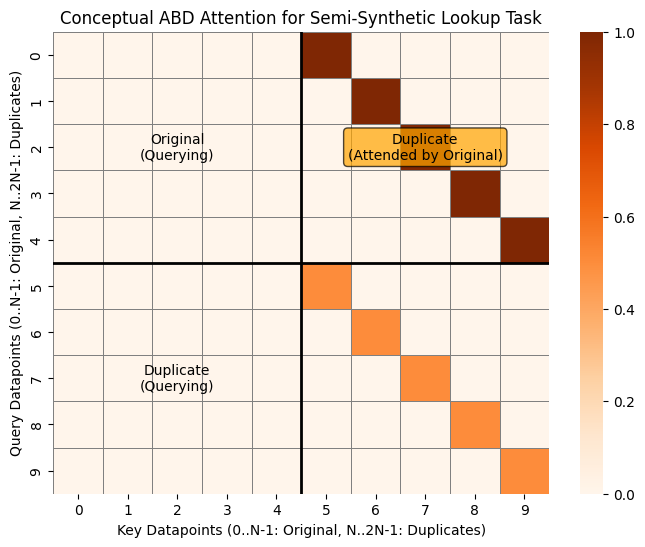

In [7]:
def plot_lookup_attention_concept(num_original_points=5):
    total_points = num_original_points * 2
    # Rows 0 to num_original_points-1 are original (targets masked)
    # Rows num_original_points to total_points-1 are duplicates (targets revealed)

    # Ideal attention: original_i attends to duplicate_i
    ideal_attn = np.zeros((total_points, total_points))
    for i in range(num_original_points):
        ideal_attn[i, i + num_original_points] = 1.0 # Original i attends to its duplicate
        # Duplicates might attend to themselves or other duplicates (less critical for lookup task)
        ideal_attn[i + num_original_points, i + num_original_points] = 0.5

    plt.figure(figsize=(8, 6))
    sns.heatmap(ideal_attn, annot=False, cmap='Oranges', linewidths=.5, linecolor='gray')
    plt.title('Conceptual ABD Attention for Semi-Synthetic Lookup Task')
    plt.xlabel('Key Datapoints (0..N-1: Original, N..2N-1: Duplicates)')
    plt.ylabel('Query Datapoints (0..N-1: Original, N..2N-1: Duplicates)')

    # Add lines to separate original and duplicate sections
    plt.axhline(y=num_original_points, color='k', linewidth=2)
    plt.axvline(x=num_original_points, color='k', linewidth=2)

    plt.text(num_original_points/2, num_original_points/2, 'Original\n(Querying)', ha='center', va='center')
    plt.text(num_original_points*1.5, num_original_points/2, 'Duplicate\n(Attended by Original)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="orange", ec="black", lw=1, alpha=0.7))
    plt.text(num_original_points/2, num_original_points*1.5, 'Duplicate\n(Querying)', ha='center', va='center')
    plt.savefig('lookup_attention_concept.png')
    plt.show()

plot_lookup_attention_concept()

The orange cells in the top-right quadrant of the conceptual heatmap indicate that original datapoints (with masked targets) are strongly attending to their corresponding duplicate datapoints (with revealed targets) to perform the lookup.

<a id='real-data-attention'></a>
### 4.3. Q3 & Q4: Using Inter-Datapoint Attention on Real Data [1, Section 4.3, 4.4]

**Q3: Do NPTs use attention between datapoints on real data?**

**Corruption Experiment (Table 2):**
- **Setup:** To test if NPT predictions depend on other datapoints at test time, for each target test datapoint, the information from *all other test datapoints* in its batch was corrupted (by shuffling their attributes independently across rows).
- **Hypothesis:** If NPTs rely on other datapoints, their performance should degrade significantly when this contextual information is destroyed.
- **Results:** For most datasets (e.g., Protein, Yacht, CIFAR-10, MNIST), NPT performance dropped significantly (e.g., -52% RMSE change for Yacht, -21% for Protein, -1.2% accuracy for CIFAR-10). This indicates that NPTs *do* successfully learn to make predictions supported by attention between datapoints.
- **Interesting Finding:** On some datasets (e.g., Forest Cover, Kick, Breast Cancer), performance did not drop much. This suggests NPTs can learn end-to-end *when* to rely on other datapoints. If inter-datapoint attention isn't beneficial, they can learn to ignore other inputs and behave more like a standard parametric model.

**Q4: What is the nature of these interactions? Which datapoints are relevant?**

**Qualitative Evidence (Attention Maps - Fig 4):**
- ABD attention maps were visualized for the Protein regression dataset.
- Input data was sorted by input space distance (similar datapoints are close to each other).
- The attention maps often showed a **diagonal pattern**, indicating that NPTs tend to attend more strongly to datapoints that are *similar in feature space*.

**Quantitative Evidence (Data Deletion Experiment):**
- **Setup:** For a test point, iteratively delete other datapoints from the input batch if their removal doesn't significantly change the prediction for the test point.
- **Analysis:** Compare the average input feature space distance between the test point and the *kept* datapoints versus the *deleted* datapoints.
- **Results:** Kept datapoints had a significantly lower average feature space distance to the test point than deleted ones (Wilcoxon signed-rank test p ≈ 8.77 * 10^-130).
- **Conclusion:** NPTs primarily rely on *similar* datapoints for prediction in real data settings. This could be, for instance, to average out observation noise from different but similar instances.

Let's visualize the diagonal attention pattern concept:

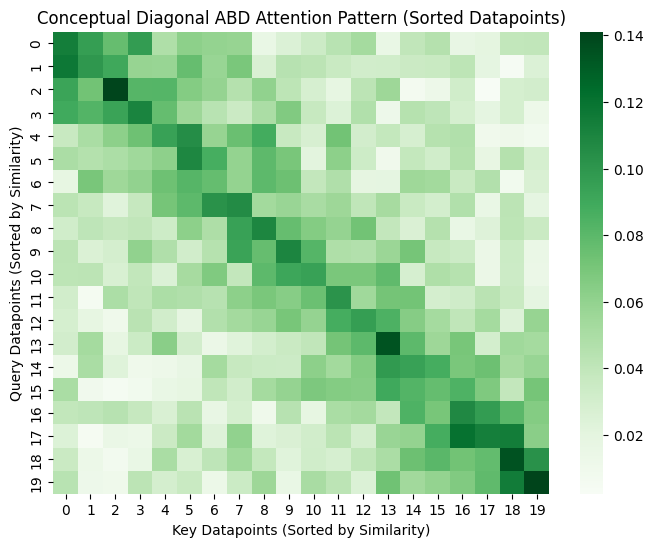

In [8]:
def plot_diagonal_attention_concept(num_points=20):
    # Simulate attention where points attend to nearby (similar) points
    attn_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distance = abs(i - j)
            # Higher attention for closer points (exponential decay)
            attn_matrix[i, j] = np.exp(-distance / (num_points / 5))
    # Normalize rows to sum to 1 (like softmax)
    attn_matrix = attn_matrix / attn_matrix.sum(axis=1, keepdims=True)

    # Introduce some noise/spread
    attn_matrix += np.random.rand(num_points, num_points) * 0.1
    attn_matrix = attn_matrix / attn_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_matrix, annot=False, cmap='Greens')
    plt.title('Conceptual Diagonal ABD Attention Pattern (Sorted Datapoints)')
    plt.xlabel('Key Datapoints (Sorted by Similarity)')
    plt.ylabel('Query Datapoints (Sorted by Similarity)')
    plt.savefig('diagonal_attention_concept.png')
    plt.show()

plot_diagonal_attention_concept()

The heatmap shows that datapoints (queries, on the y-axis) tend to pay more attention to other datapoints (keys, on the x-axis) that are close to them on the diagonal. Since the datapoints are sorted by similarity, this indicates attention to similar instances.

<a id='ablation'></a>
## 5. Ablation Studies: What Makes NPTs Tick? [1, Appendix B.4, B.5]

Ablation studies involve removing or altering components of a model to understand their contribution to performance.

**Key Ablations and Findings:**

1.  **NPT Hyperparameters (Appendix B.4, Table 4):**
    *   NPTs were found to be generally robust to a variety of hyperparameter choices (e.g., number of layers, heads, masking probabilities).
    *   Performance didn't drastically change with moderate alterations, suggesting practitioners might not need extensive hyperparameter tuning for NPTs to work reasonably well.
    *   However, very dramatic changes, like removing feature masking entirely or very high feature masking rates, could degrade performance on some datasets (e.g., Protein).

2.  **Impact of ABA Layer (Appendix B.5, Table 5):**
    *   **Setup:** NPTs were trained without the Attention Between Attributes (ABA) layers. In this case, the MLP at the end of ABD layers (the row-wise Feed Forward, rFF) is the only component that transforms features of input datapoints independently.
    *   **Results:** Generally, ABA was found to be a useful component. Removing it decreased performance on 7 out of 10 datasets. The largest drop was on the Poker Hand dataset (accuracy from 99.3% to 57.4%), which requires complex reasoning between input features.
    *   **Conclusion:** ABA is beneficial when the dataset requires complex transformations of features within each datapoint. The default recommendation is to use NPTs with ABA layers.

3.  **Impact of Stochastic Feature Masking (Appendix B.5, Table 5):**
    *   **Setup:** NPTs were trained without any stochastic masking of input features (`p_feature = 0`).
    *   **Results:** For 9 out of 10 datasets, enabling feature masking yielded at least a small improvement. Disabling it was detrimental for Poker Hand (30% accuracy drop).
    *   **Conclusion:** Stochastic feature masking acts as effective regularization and encourages the model to learn more robust and generalizable representations. It's generally recommended.

**Overall Implication:**
The ablation studies support that NPTs are relatively robust architectures. The core components like ABA and feature masking contribute positively to performance, especially on complex tasks. The architecture's design allows it to adapt—if certain components (like inter-datapoint attention) aren't useful for a particular dataset, the model can learn to downplay their influence.

<a id='computational-societal'></a>
## 6. Computational Considerations and Societal Impacts

### 6.1. Computational Cost [1, Section 5 (Limitations), Appendix B.6]

- **Scaling Limitations:** NPTs share scaling limitations with naive non-parametric approaches and GNNs due to the `O(n^2)` complexity of self-attention with respect to the number of datapoints `n`.
- **Memory Usage:** Processing the entire dataset (or large minibatches containing diverse data) means NPTs can be GPU-memory intensive. For example, on the Higgs dataset (11M datapoints), NPT used 19.18 GB GPU memory during training, compared to 1.18 GB for TabNet. [1, Table 7]
- **Training Time:** NPTs generally require longer training times than non-neural baselines if hyperparameter tuning for baselines is excluded. For instance, on the Protein dataset (45k datapoints), NPT trained in ~11 hours, while boosting models finished in <1 hour (including their HPO). However, for very large datasets like Higgs, NPT took ~5.8 days, while Random Forest took ~13.5 days. [1, Table 6, 7]
- **Minibatching:** As discussed, random minibatching is used, but ensuring training and test data are in the same batch for test-time attention adds complexity.
- **Future Work for Scalability:** The paper suggests exploring principled attention approximations like learning representative input points, kernelization, or other sparsity-inducing methods to improve scalability.

### 6.2. Societal Impacts [1, Appendix F]

Applying any machine learning model, including NPTs, in real-world scenarios requires careful consideration of societal impacts.

- **Explainability ("Right to Explanation"):**
    *   Transformer-based architectures, including NPTs, can be amenable to explanations (e.g., by examining attention weights).
    *   The NPT experiments on which datapoints are attended to (Section 4.4) move in an explanatory direction.
    *   However, detailed investigation of individual NPT decisions is needed.

- **Fairness:**
    *   The predictive behavior of NPTs relies on similar datapoints. This poses challenges and opportunities for fairness.
    *   Bias in the training data (e.g., underrepresentation) could be amplified if the model primarily attends to dominant groups.
    *   Conversely, the ability to be "prompted" with a different set of context datapoints at test time could potentially be used to guide NPTs towards fairer predictions without full retraining, though this is speculative and needs research.

- **Privacy:**
    *   NPTs directly use training data (or parts of it) during prediction. This means they are **not private by definition** if the raw training data is used in the context set.
    *   This raises concerns if sensitive data is involved.
    *   Future work might explore learning to predict from anonymized or representative (synthetic) datapoints instead of raw training data.

- **Environmental Impact:**
    *   At the model sizes presented in the paper, the impact is relatively small compared to very large language models.
    *   However, if NPTs are scaled up, the energy for training and prediction could become a concern.
    *   The paper notes that while training a single NPT might be more expensive than a single tree-based model, the latter often require extensive hyperparameter tuning, potentially evening out the total compute.

**Recommendation:** The paper advises that NPTs are a new architecture and should not be carelessly applied in production settings where explanations, fairness, or privacy are critical or legally required, without further dedicated research into these aspects for NPTs.

<a id='interactive'></a>
## 7. Interactive Playground

Let's use `ipywidgets` to interactively explore some concepts related to attention in NPTs.

### 7.1. Simulating ABD Attention Strength

We can simulate how the "similarity" between datapoints might influence attention weights in ABD. We'll create a dummy similarity matrix and then derive attention weights, allowing you to adjust a "focus" parameter.

In [1]:
from ipywidgets import interact, FloatSlider, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def simulate_abd_attention(num_datapoints=10, focus_param=1.0):
    """
    Simulates ABD attention weights based on a conceptual similarity.
    focus_param: Higher values make attention sharper (more focused on most similar).
    """
    # Create a dummy 'feature space' for datapoints
    np.random.seed(42)
    features = np.random.rand(num_datapoints, 5) # 5 features

    # Calculate pairwise Euclidean distances (lower distance = higher similarity)
    dist_matrix = np.zeros((num_datapoints, num_datapoints))
    for i in range(num_datapoints):
        for j in range(num_datapoints):
            dist_matrix[i,j] = np.linalg.norm(features[i] - features[j])

    # Convert distance to similarity (e.g., using Gaussian kernel idea)
    # Higher scores for more similar (less distant) items
    # This simulates the QK^T part, scaled by focus_param
    similarity_scores = np.exp(-dist_matrix * focus_param)

    # Apply softmax row-wise to get attention weights
    exp_scores = np.exp(similarity_scores)
    attention_weights = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    plt.figure(figsize=(8,6))
    sns.heatmap(attention_weights, annot=False, cmap='Reds', vmin=0, vmax=max(0.1, np.max(attention_weights)))
    plt.title(f'Simulated ABD Attention (Focus: {focus_param:.2f})')
    plt.xlabel('Key Datapoints')
    plt.ylabel('Query Datapoints')
    plt.show()

interact(
    simulate_abd_attention,
    num_datapoints=IntSlider(min=5, max=20, step=1, value=10, description='Datapoints:'),
    focus_param=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Focus:')
)

ModuleNotFoundError: No module named 'ipywidgets'

**Interactive Exploration:**
- **Datapoints:** Change the number of datapoints in the simulation.
- **Focus:** Adjust the `focus_param`. A higher value will make the attention sharper, concentrating more weight on the most similar datapoints (closer to a k-NN like behavior). A lower value will spread the attention more broadly.

This simulation helps visualize the NPT paper's finding that ABD often attends to similar datapoints.

### 7.2. Simulating ABA: Attribute Interaction Strength

For ABA, we can simulate how different attributes within a *single* datapoint might interact. Let's imagine some attributes are inherently more correlated.

In [10]:
def simulate_aba_attention(num_attributes=6, correlation_strength=0.8):
    """
    Simulates ABA attention weights for a single datapoint.
    correlation_strength: How much predefined pairs of attributes should attend to each other.
    """
    np.random.seed(123)
    # Base attention (e.g., from random Q, K initializations)
    base_scores = np.random.rand(num_attributes, num_attributes) * 0.2 # Add some base noise/connectivity

    # Introduce some predefined correlations (simulating learned feature interactions)
    # For example, attribute 0 and 1 are correlated, attribute 2 and 3 are correlated
    if num_attributes >= 2:
        base_scores[0, 1] += correlation_strength
        base_scores[1, 0] += correlation_strength
    if num_attributes >= 4:
        base_scores[2, 3] += correlation_strength
        base_scores[3, 2] += correlation_strength
    if num_attributes >= 6:
        base_scores[4, 5] += correlation_strength
        base_scores[5, 4] += correlation_strength

    # Ensure self-attention is reasonably high
    np.fill_diagonal(base_scores, np.diag(base_scores) + correlation_strength * 0.5)

    # Apply softmax row-wise
    exp_scores = np.exp(base_scores)
    attention_weights = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    plt.figure(figsize=(8,6))
    custom_labels = [f'Attr {i+1}' for i in range(num_attributes)]
    sns.heatmap(attention_weights, annot=True, cmap='Blues', fmt=".2f", xticklabels=custom_labels, yticklabels=custom_labels, vmin=0, vmax=max(0.1, np.max(attention_weights)))
    plt.title(f'Simulated ABA Attention (Correlation Strength: {correlation_strength:.2f})')
    plt.xlabel('Key Attributes')
    plt.ylabel('Query Attributes')
    plt.show()

interact(
    simulate_aba_attention,
    num_attributes=IntSlider(min=3, max=8, step=1, value=6, description='Attributes:'),
    correlation_strength=FloatSlider(min=0.0, max=2.0, step=0.1, value=0.8, description='Correlation:')
);

interactive(children=(IntSlider(value=6, description='Attributes:', max=8, min=3), FloatSlider(value=0.8, desc…

**Interactive Exploration:**
- **Attributes:** Change the number of attributes for the datapoint.
- **Correlation:** Adjust the `correlation_strength`. Higher values will make the predefined correlated pairs (e.g., Attr1-Attr2, Attr3-Attr4) attend more strongly to each other. This simulates how ABA might learn that certain features within a datapoint are highly informative for each other.

These interactive examples are simplified, but they aim to give a feel for how the attention mechanisms in NPTs might operate and what kind of patterns they could learn.

<a id='conclusion'></a>
## 8. Conclusion

Non-Parametric Transformers (NPTs) present a significant conceptual shift in deep learning by processing entire datasets and explicitly modeling inter-datapoint relationships. This is achieved through a novel architecture that alternates Attention Between Datapoints (ABD) and Attention Between Attributes (ABA).

**Key Takeaways from the Research Paper:**
- **Novel Paradigm:** NPTs learn end-to-end *how* to use other datapoints for prediction, combining strengths of parametric attention with non-parametric modeling principles.
- **Strong Empirical Performance:** NPTs are competitive and sometimes superior on standard tabular data benchmarks, and show promise on image data, without task-specific architectural components for tabular data.
- **Learned Interactions:** Experiments demonstrate that NPTs can learn complex lookup tasks and that their predictions on real-world data often rely on attending to similar datapoints.
- **Robustness and Adaptability:** NPTs appear robust to hyperparameter choices and can learn to ignore inter-datapoint attention if it's not beneficial for a specific dataset.
- **Challenges:** Scalability to very large datasets remains a challenge due to the quadratic complexity of self-attention, though minibatching strategies are employed.

NPTs open up exciting avenues for future research, including:
- Improving scalability through attention approximation techniques.
- Exploring applications in continual learning, few-shot generalization, and domain adaptation, where leveraging relationships with prior data is crucial.
- Deeper investigation into the explainability, fairness, and privacy aspects of models that directly use training data at prediction time.

This notebook aimed to provide a beginner-friendly yet in-depth overview of NPTs, drawing from the original research. By understanding their architecture, how they learn, and their potential, we can appreciate their contribution to the evolving landscape of deep learning.

---
**Reference:**
[1] Kossen, J., Band, N., Lyle, C., Gomez, A. N., Rainforth, T., & Gal, Y. (2022). Self-Attention Between Datapoints: Going Beyond Individual Input-Output Pairs in Deep Learning. arXiv preprint arXiv:2106.02584v2.